In [1]:
import os
import json
import copy

with open(os.path.join(os.getcwd(), os.pardir, os.pardir, "02 data", "01 test 1", "Oft 1_superanimal_topviewmouse_fasterrcnn_resnet50_fpn_v2_hrnet_w32_before_adapt.json")) as f:
    global raw_data
    raw_data = json.load(f)

# Defining of constant for preprocessing of json

In [2]:
number_of_animals = 2

parts_of_interest = {"head": 0} # part name and it's index in the list

# Removal of Unnecessary Data

* we remove animals that are not tracked for example if we have 2 animals then we'll remove the index from **[2]** to **[9]**

In [3]:
data = copy.deepcopy(raw_data)

for frame in data:
    if 'bboxes' in frame:
        frame['bboxes'] = frame['bboxes'][:number_of_animals]
    if 'bbox_scores' in frame:
        frame['bbox_scores'] = frame['bbox_scores'][:number_of_animals]
    if 'bodyparts' in frame:
        frame['bodyparts'] = frame['bodyparts'][:number_of_animals]

print(len(data[0]['bbox_scores']))
print(data[0]['bbox_scores'])

2
[0.9999990463256836, 0.9990359544754028]


In [4]:
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

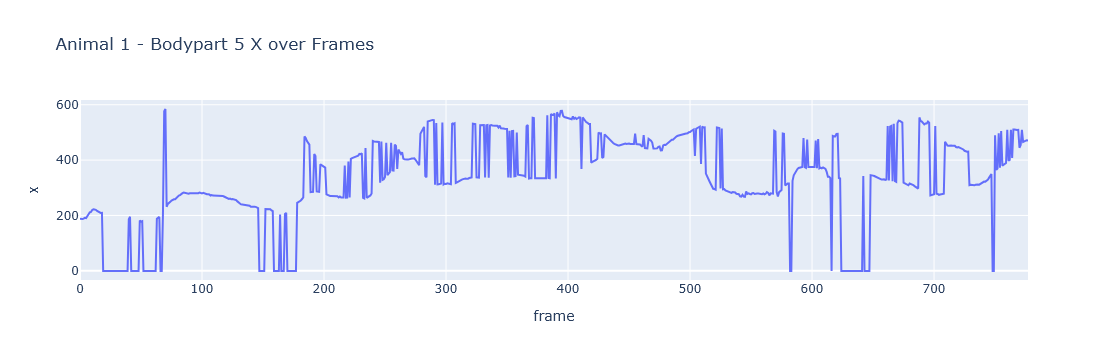

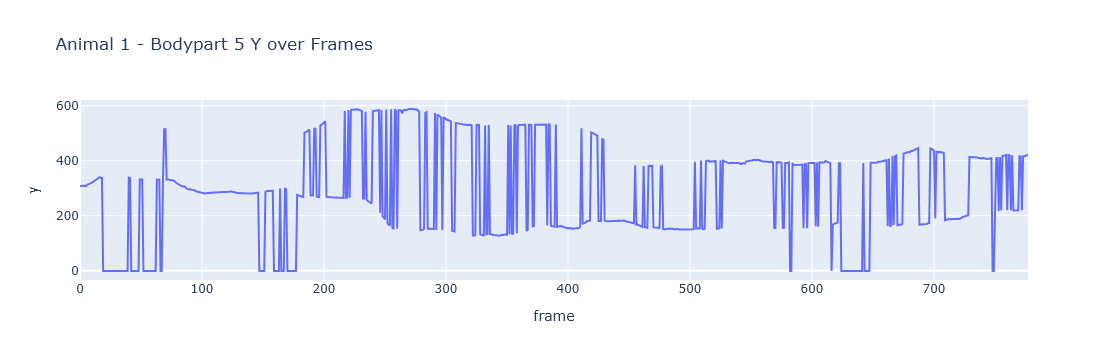

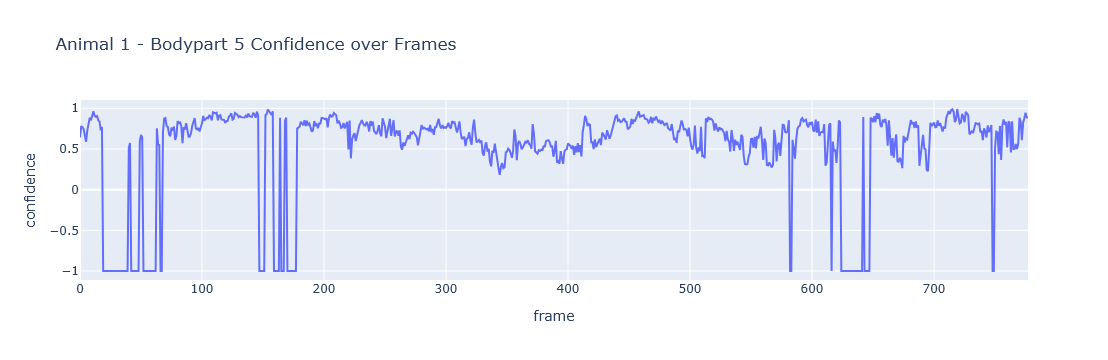

In [10]:
# User can change these indices as needed
animal_index = 1      # index of the animal (for multi-animal experiments)
bodypart_index = 5    # index of the specific bodypart to plot

# Extract frame-wise coordinates and confidence
records = []
for frame_idx, frame in enumerate(data):
    bodyparts = frame.get('bodyparts', [])
    if len(bodyparts) > animal_index and len(bodyparts[animal_index]) > bodypart_index:
        x, y, p = bodyparts[animal_index][bodypart_index]
    else:
        x, y, p = None, None, None
    records.append({"frame": frame_idx, "x": x, "y": y, "confidence": p})

df = pd.DataFrame(records)

# Plot X coordinate over frames
fig_x = px.line(df, x='frame', y='x',
                title=f'Animal {animal_index} - Bodypart {bodypart_index} X over Frames')
fig_x.show()

# Plot Y coordinate over frames
fig_y = px.line(df, x='frame', y='y',
                title=f'Animal {animal_index} - Bodypart {bodypart_index} Y over Frames')
fig_y.show()

# Plot confidence score over frames
fig_p = px.line(df, x='frame', y='confidence',
                title=f'Animal {animal_index} - Bodypart {bodypart_index} Confidence over Frames')
fig_p.show()



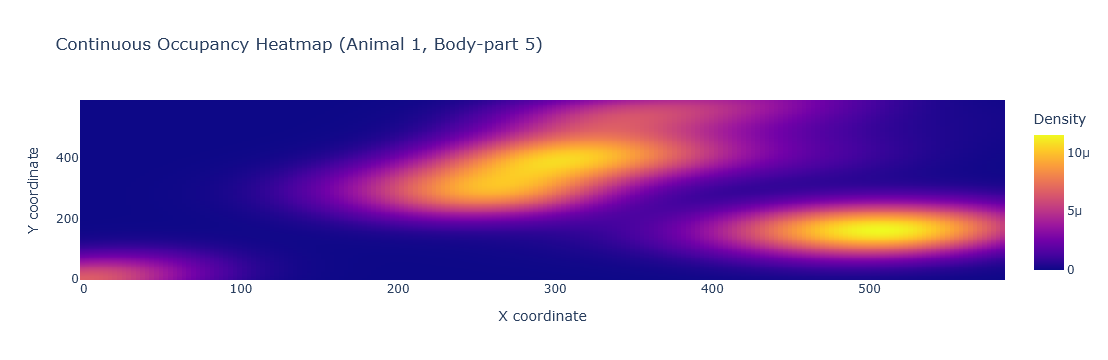

In [11]:
grid_size       = 200                     # resolution of the density grid

xs, ys = [], []
for frame in data:
    bps = frame.get('bodyparts', [])
    if len(bps) > animal_index and len(bps[animal_index]) > bodypart_index:
        x, y, _ = bps[animal_index][bodypart_index]
        xs.append(x)
        ys.append(y)

# Drop any NaNs
coords = np.vstack([xs, ys])
mask = ~np.isnan(coords).any(axis=0)
coords = coords[:, mask]

# ——— GAUSSIAN KDE DENSITY ESTIMATE ———
kde = gaussian_kde(coords)
xmin, ymin = coords.min(axis=1)
xmax, ymax = coords.max(axis=1)

xi = np.linspace(xmin, xmax, grid_size)
yi = np.linspace(ymin, ymax, grid_size)
xx, yy = np.meshgrid(xi, yi)
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
zi = kde(grid_coords).reshape(xx.shape)

# ——— PLOTLY HEATMAP ———
fig = go.Figure(go.Heatmap(
    z=zi,
    x=xi,
    y=yi,
    colorbar=dict(title='Density')
))
fig.update_layout(
    title=f'Continuous Occupancy Heatmap (Animal {animal_index}, Body-part {bodypart_index})',
    xaxis_title='X coordinate',
    yaxis_title='Y coordinate'
)
fig.show()
